In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
import astropy.constants as cons
import astropy.units as u
import astropy.cosmology as cosmo

# %matplotlib notebook

In [2]:
def distance(x0,x1,y0,y1):
    return np.sqrt((x0-x1)**2 + (y0-y1)**2)

## Define cosmological model  ( Matter only universe )
cosmo1 = cosmo.FlatLambdaCDM(H0=70, Om0=1.0, Tcmb0=2.725)

## Reading the initial conditions for N body 

In [3]:
IC_position = np.genfromtxt("IC_position__CDM_0_434349__Baryons_0_02203__grid_64_length_64.txt")
IC_velocity = np.genfromtxt("IC_velocity__CDM_0_434349__Baryons_0_02203__grid_64_length_64.txt")

#### Reading initial positions
## unit is 'Mpc/h'
x0_array = IC_position[:,0]
y0_array = IC_position[:,1]
z0_array = IC_position[:,2]

#### Reading initial velocity
## unit is 'Km/s'
vx0_array = IC_velocity[:,0]
vy0_array = IC_velocity[:,1]
vz0_array = IC_velocity[:,2]

# Initially take a mass scale as 1 unit to make simulation easy, then multiply with the mass particle at end
mass_array = np.ones(len(x0_array))

In [4]:
### Initializing 'h0'
h0 = 100*(u.km).to(u.Mpc)/(((u.second).to(u.Gyr)))   ### in 'h s^{-1}'

### Define h
h = 0.7

## Defining proper times
time0 = cosmo1.age(0).value  *h         ### In 'Gyr' / h
time100 = cosmo1.age(z=100).value *h    ### In 'Gyr' / h
time90 = cosmo1.age(z=90).value *h      ### In 'Gyr' / h 

### Defining conformal time ( eta )
eta0 = (2/h0)**(2/3) * (time0/3)**(1/3)    ### In 'Gyr' / h

####  Starting and ending red shift of our simulation
start_red_shift = 100
end_red_shift = 90

### Starting and ending eta of our simulation
eta_start = eta0 / ( ( 1 + start_red_shift)**(1/2))
eta_end = eta0 / ( ( 1 + end_red_shift)**(1/2))


## Number of steps
Nsteps = 20
Dt = (eta_end - eta_start)/(Nsteps-1)     ### In 'Gyr'
eta = np.arange(eta_start,eta_end,Dt)    ### In 'Gyr'

### Just to check how photon travels in grids with the chosen time steps

### Mpc travel by photon in a single time step (Dt is in 'Gyr')
c_in_Mpc_Gyr = (u.m).to(u.Mpc)*3*1e8*(u.Mpc)/(((u.second).to(u.Gyr))*u.Gyr)
print("Distance travelled by photon in a single time step = ",c_in_Mpc_Gyr*Dt*(u.Gyr))

Distance travelled by photon in a single time step =  0.8083528999673596 Mpc


###  Grid for Simulation Box

In [5]:
## Defining the mesh 

## The 1 dimensional length of the simulation box is defined below,
length = 64      ## in Mpc/h

## N is number of grid points
N = 64

##### Average Density of the universe at the red shift of given initial power spectrum ,
## Here power spectrum is given at z = 100 ( it scales with 1/a^3)
average_density_z100 = cosmo1.critical_density(z=100).to(u.kg/(h*u.Mpc)**3).value 

## As we have N^3 particles , we need to assign mass of the particle such that in the given volume 
## the average density of the box would be same as average density of the universe.
mass_particle = average_density_z100* (length*(1/101)/N)**3     ### Length is scaled with a^3 


## Smallest distance between two grid points,
dx = length/N

## Defining bin edge for the 3 Dimensional array 
bin_edges = np.arange(N+1)*dx

## Defining the grid centers 
grid = (np.roll(bin_edges,-1)+bin_edges)[:-1]/2

## Frequency for the given grid points
k_array = np.fft.fftfreq(N,d=dx)

## k_power_spectrum is the frequency array which has all positive frequencies from zeros to the k_power_spectrum_highest
## For the cubic box we consider sqrt(3)*max(k_array)  which is length of 3 D diagonal in the box 
k_power_spectrum = np.linspace(0,np.sqrt(3*(np.max(np.abs(k_array))**2)),30)

### To save power spectrum at each red shift
power_spectrum_array = np.zeros((Nsteps,len(k_power_spectrum)))

## The below indexes are used in the poisson solver
J = N
L = N
O = N

## Now construct a rho grid with the Halo = 1 .  means extra 1 column in each direction. This is helpful to
## implement periodic boundary condition in projection
x_array_CIC = np.hstack((grid[0]-dx,grid,grid[-1]+dx))
y_array_CIC = np.hstack((grid[0]-dx,grid,grid[-1]+dx))
z_array_CIC = np.hstack((grid[0]-dx,grid,grid[-1]+dx))

#### Initializing an array a_arr to store the scale factor values.
a_arr = np.zeros(Nsteps)

### Initializing Red shift array 
red_shift = np.zeros(Nsteps)

#### Converintg 'G' into the unit of Mpc and Gyr
G = ((cons.G).to((u.Mpc**3)/(u.kg*(u.Gyr**2)))).value

# ## Speed of light in Mpc/s
# c_in_Mpc_s = (300000*(u.km).to(u.Mpc))

# ### A Photon would take below years to travel one cell in box
# years_per_cell = (dx*(u.second).to(u.yr))/(c_in_Mpc_s)
mass_particle, mass_particle*(N**3)/(length*(1/101))**3 , average_density_z100

(9.35491419409042e+40, 9.638377449085553e+46, 9.638377449085553e+46)

In [6]:
### Initializing positions of the particles
x_array = np.zeros((Nsteps,len(mass_array)))
y_array = np.zeros((Nsteps,len(mass_array)))
z_array = np.zeros((Nsteps,len(mass_array)))
x_array[0] = x0_array
y_array[0] = y0_array
z_array[0] = z0_array

### Initializing velocity of the particles
vx_array = np.zeros((Nsteps,len(mass_array)))
vy_array = np.zeros((Nsteps,len(mass_array)))
vz_array = np.zeros((Nsteps,len(mass_array)))

### Convert initial velocity unit from km/s to Mpc/yr(in Dt) 
vx0_array = (vx0_array)*((u.km).to(u.Mpc))/((u.second).to(u.Gyr))
vy0_array = (vy0_array)*((u.km).to(u.Mpc))/((u.second).to(u.Gyr))
vz0_array = (vz0_array)*((u.km).to(u.Mpc))/((u.second).to(u.Gyr))

vx_array[0] = vx0_array
vy_array[0] = vy0_array
vz_array[0] = vz0_array

### Initializing forces of the particles
force_x = np.zeros(len(mass_array))
force_y = np.zeros(len(mass_array))
force_z = np.zeros(len(mass_array))

### Initializing half time step velocity of the particles
vx_half_integer = np.zeros(len(mass_array))
vy_half_integer = np.zeros(len(mass_array))
vz_half_integer = np.zeros(len(mass_array))

# KE = np.zeros((Nsteps,len(mass_array)))
# TE = np.zeros((Nsteps,len(mass_array)))
# PE = np.zeros((Nsteps,len(mass_array)))
vx0_array

array([ 1.98579044e-04,  3.90213950e-04,  2.00205142e-04, ...,
        1.15415835e-04, -4.83565701e-05,  1.09875914e-04])

## N body evolution

In [7]:
for i in range(Nsteps-2):
# for i in range(1):

    ###################################################
    ###### Defining parameters of the universe ########
    ###################################################
    
    a_scale_factor = (eta[i]/eta0)**(2)       ###     :: scaling is remaining    
    a_sq = a_scale_factor**2
    
    a_arr[i] = a_scale_factor
    h_conformal = ( 2 / eta[i] )
    
    ### Red shift
    red_shift[i] =  (1 - a_scale_factor) / a_scale_factor 
    
    print("red shift z = ",red_shift[i])
    print(i,"_a = ",a_scale_factor)
    
    ### Deprojection of mass on the mesh points thi includes halo = 1 means 1 extra column in each directions 
    mass_grid_CIC = np.zeros((len(x_array_CIC),len(x_array_CIC),len(x_array_CIC)))
    
    for a in range(len(mass_array)):

        #########################################
        ######## CIC projection #################
        #########################################
            
        ## The below shift will push the particles from right side corner to left side
        ##  and left side outof the box to right side. Periodic Boundary condition
        if (x_array[i][a] > x_array_CIC[-1]):
            x_array[i][a] = x_array[i][a] - length
        if (y_array[i][a] > y_array_CIC[-1]):
            y_array[i][a] = y_array[i][a] - length
        if (z_array[i][a] > z_array_CIC[-1]):
            z_array[i][a] = z_array[i][a] - length

        if (x_array[i][a] < x_array_CIC[0]):
            x_array[i][a] = x_array[i][a] + length
        if (y_array[i][a] < y_array_CIC[0]):
            y_array[i][a] = y_array[i][a] + length
        if (z_array[i][a] < z_array_CIC[0]):
            z_array[i][a] = z_array[i][a] + length
        
        ## Find the four nearest 8 coordinates (in 3D) from particles
            
        a0 = np.where(np.abs(x_array[i][a]-x_array_CIC)<dx)[0][0]
        a1 = np.where(np.abs(y_array[i][a]-y_array_CIC)<dx)[0][0]
        a2 = np.where(np.abs(z_array[i][a]-z_array_CIC)<dx)[0][0]

        a0_dist = np.round(np.abs(x_array[i][a]-x_array_CIC[a0]),6)
        a1_dist = np.round(np.abs(y_array[i][a]-y_array_CIC[a1]),6)
        a2_dist = np.round(np.abs(z_array[i][a]-z_array_CIC[a2]),6)

        ### Condition if the first index is second last index of X_array_CIC which includes 1 halo 
        ### OR second index is the halo index then    
        ### it passes the value 1. ( because the 0th index is halo and we need to remove that in end.)

        if ((a0 == (len(x_array_CIC) - 1)) or (a0 + 1) == (len(x_array_CIC) - 1)):
            b0 = 1
        else: 
            b0 = a0 + 1

        b0_dist = dx - a0_dist
        b1 = a1
        b1_dist = a1_dist
        b2 = a2
        b2_dist = a2_dist

        if ((a0 == (len(x_array_CIC) - 1)) or (a0 + 1) == (len(x_array_CIC) - 1)):
            c0 = 1
        else: 
            c0 = a0 + 1
        c0_dist = dx - a0_dist

        if ((a1 == (len(x_array_CIC) - 1)) or (a1 + 1) == (len(x_array_CIC) - 1)):
            c1 = 1
        else: 
            c1 = a1 + 1
        c1_dist = dx - a1_dist
        c2 = a2
        c2_dist = a2_dist

        d0 = a0
        d0_dist = a0_dist
        if ((a1 == (len(x_array_CIC) - 1)) or (a1 + 1) == (len(x_array_CIC) - 1)):
            d1 = 1
        else: 
            d1 = a1 + 1 
        d1_dist = dx - a1_dist
        d2 = a2
        d2_dist = a2_dist

        e0 = a0 
        e0_dist = a0_dist
        e1 = a1
        e1_dist = a1_dist
        if ((a2 == (len(x_array_CIC) - 1)) or (a2 + 1) == (len(x_array_CIC) - 1)):
            e2 = 1
        else: 
            e2 = a2 + 1
        e2_dist = dx - a2_dist

        if ((a0 == (len(x_array_CIC) - 1)) or (a0 + 1) == (len(x_array_CIC) - 1)):
            f0 = 1
        else: 
            f0 = a0 + 1
        f0_dist = dx - a0_dist
        f1 = a1
        f1_dist = a1_dist
        if ((a2 == (len(x_array_CIC) - 1)) or (a2 + 1) == (len(x_array_CIC) - 1)):
            f2 = 1
        else: 
            f2 = a2 + 1 
        f2_dist = dx - a2_dist

        if ((a0 == (len(x_array_CIC) - 1)) or (a0 + 1) == (len(x_array_CIC) - 1)):
            g0 = 1
        else: 
            g0 = a0 + 1
        g0_dist = dx - a0_dist

        if ((a1 == (len(x_array_CIC) - 1)) or (a1 + 1) == (len(x_array_CIC) - 1)):
            g1 = 1
        else: 
            g1 = a1 + 1
        g1_dist = dx - a1_dist
        if ((a2 == (len(x_array_CIC) - 1)) or (a2 + 1) == (len(x_array_CIC) - 1)):
            g2 = 1
        else: 
            g2 = a2 + 1 
        g2_dist = dx - a2_dist

        h0 = a0 
        h0_dist = a0_dist
        if ((a1 == (len(x_array_CIC) - 1)) or (a1 + 1) == (len(x_array_CIC) - 1)):
            h1 = 1
        else: 
            h1 = a1 + 1
        h1_dist = dx - a1_dist
        if ((a2 == (len(x_array_CIC) - 1)) or (a2 + 1) == (len(x_array_CIC) - 1)):
            h2 = 1
        else: 
            h2 = a2 + 1
        h2_dist = dx - a2_dist        

        ### Now if the first index is 0 (Halo column index) then it should pass the value to 
        ### Second last column ... so after removing last column (Halo) we will get the final projection.
        if ( a0 == 0 ):
            a0 = len(x_array_CIC) - 2
        if ( a1 == 0 ):
            a1 = len(x_array_CIC) - 2
        if ( a2 == 0 ):
            a2 = len(x_array_CIC) - 2

        if ( b0 == 0 ):
            b0 = len(x_array_CIC) - 2
        if ( b1 == 0 ):
            b1 = len(x_array_CIC) - 2
        if ( b2 == 0 ):
            b2 = len(x_array_CIC) - 2

        if ( c0 == 0 ):
            c0 = len(x_array_CIC) - 2
        if ( c1 == 0 ):
            c1 = len(x_array_CIC) - 2
        if ( c2 == 0 ):
            c2 = len(x_array_CIC) - 2

        if ( d0 == 0 ):
            d0 = len(x_array_CIC) - 2
        if ( d1 == 0 ):
            d1 = len(x_array_CIC) - 2
        if ( d2 == 0 ):
            d2 = len(x_array_CIC) - 2

        if ( e0 == 0 ):
            e0 = len(x_array_CIC) - 2
        if ( e1 == 0 ):
            e1 = len(x_array_CIC) - 2
        if ( e2 == 0 ):
            e2 = len(x_array_CIC) - 2

        if ( f0 == 0 ):
            f0 = len(x_array_CIC) - 2
        if ( f1 == 0 ):
            f1 = len(x_array_CIC) - 2
        if ( f2 == 0 ):
            f2 = len(x_array_CIC) - 2

        if ( g0 == 0 ):
            g0 = len(x_array_CIC) - 2
        if ( g1 == 0 ):
            g1 = len(x_array_CIC) - 2
        if ( g2 == 0 ):
            g2 = len(x_array_CIC) - 2

        if ( h0 == 0 ):
            h0 = len(x_array_CIC) - 2
        if ( h1 == 0 ):
            h1 = len(x_array_CIC) - 2
        if ( h2 == 0 ):
            h2 = len(x_array_CIC) - 2

        mass_grid_CIC[a0][a1][a2] += np.round(g0_dist*g1_dist*g2_dist/dx**3,6)*mass_array[a]*mass_particle
        mass_grid_CIC[b0][b1][b2] += np.round(h0_dist*h1_dist*h2_dist/dx**3,6)*mass_array[a]*mass_particle
        mass_grid_CIC[c0][c1][c2] += np.round(e0_dist*e1_dist*e2_dist/dx**3,6)*mass_array[a]*mass_particle
        mass_grid_CIC[d0][d1][d2] += np.round(f0_dist*f1_dist*f2_dist/dx**3,6)*mass_array[a]*mass_particle

        mass_grid_CIC[e0][e1][e2] += np.round(c0_dist*c1_dist*c2_dist/dx**3,6)*mass_array[a]*mass_particle
        mass_grid_CIC[f0][f1][f2] += np.round(d0_dist*d1_dist*d2_dist/dx**3,6)*mass_array[a]*mass_particle
        mass_grid_CIC[g0][g1][g2] += np.round(a0_dist*a1_dist*a2_dist/dx**3,6)*mass_array[a]*mass_particle
        mass_grid_CIC[h0][h1][h2] += np.round(b0_dist*b1_dist*b2_dist/dx**3,6)*mass_array[a]*mass_particle

    density_grid = mass_grid_CIC[1:-1,1:-1,1:-1]/( (a_scale_factor*dx)**3 )   
    #######################################################
    ### Calculating critical density at the given red shift
#     rho_average =  cosmo1.critical_density(z=100).to(u.kg/(h*u.Mpc)**3).value / (a_scale_factor**3)
    rho_average = np.mean(density_grid)
    print("average = " ,rho_average)
    rho_average_check = cosmo1.critical_density(z=red_shift[i]).to(u.kg/(h*u.Mpc)**3).value 
    print(" average check = ",rho_average_check)
    
    
    ###################################################
    ##### Generating power spectrum at each time ######
    ###################################################
    
    delta_grid = (density_grid - rho_average)/rho_average
    
    delta_check_FFT = np.fft.fftn(delta_grid)/(N**3)

    power_spectrum = np.zeros(len(k_power_spectrum))
    count = np.zeros(len(k_power_spectrum))

    for m in range(len(k_array)):
        for n in range(len(k_array)):
            for o in range(len(k_array)):

                k_norm = np.sqrt(k_array[m]**2+k_array[n]**2+k_array[o]**2)

                power_spectrum[np.abs(k_norm-k_power_spectrum).argmin()] += np.abs(delta_check_FFT[m][n][o])**2
                count[np.abs(k_norm-k_power_spectrum).argmin()] += 1
        print(m,end="\r")

    power_spectrum_array[i] = power_spectrum*(N**3)*((length/(2*np.pi))**(3))/(count)
    
    #####################################################
    ################# Poisson solver ####################
    #####################################################
    
    ### Calculating the FFT of potential using the FFT of the density on mesh
    
#     fullRho_grid = (4*(a_sq)*np.pi*G*(density_grid-rho_average))

    fullRho_grid = (3/2)*h0*h0*delta_grid*a_scale_factor
    
    ### Finding the FFT of the rho grid
    
    rho_fft = np.zeros((len(grid),len(grid),len(grid)),dtype=complex)
    rho_fft = np.fft.fftn(fullRho_grid)
    
    phi_fft_grid = np.zeros((len(grid),len(grid),len(grid)),dtype=complex)
    
    for m in range(len(grid)):
        for n in range(len(grid)):
            for o in range(len(grid)):

                if ((m != 0) or (n != 0) or (o != 0)):

                    phi_fft_grid[m][n][o] = (rho_fft[m][n][o]*dx**2)/(2*(np.cos(2*np.pi*m/J)+np.cos(2*np.pi*n/L)+np.cos(2*np.pi*o/O)-3)) 

    phi_fft_grid[0][0][0] = 0 + 0j
    
    ## Calculating the potential on the mesh point from the FFT
    
    phi_grid = np.zeros((len(grid),len(grid),len(grid)),dtype=complex)
    phi_grid = np.fft.ifftn(phi_fft_grid)
    
    ## Calculating Force on grid point using finite difference of potential
    
    ## 3D force
    force_x_grid = (np.real(np.roll(phi_grid,shift=-1,axis=0)-np.roll(phi_grid,shift=1,axis=0))/(2*dx))
    force_y_grid = (np.real(np.roll(phi_grid,shift=-1,axis=1)-np.roll(phi_grid,shift=1,axis=1))/(2*dx))
    force_z_grid = (np.real(np.roll(phi_grid,shift=-1,axis=2)-np.roll(phi_grid,shift=1,axis=2))/(2*dx))

    force_x = np.zeros(len(mass_array))
    force_y = np.zeros(len(mass_array))
    force_z = np.zeros(len(mass_array))
    
    #####################################
    ###### Motion of particles ##########
    #####################################
    
    for a in range(len(mass_array)):
        
        ##################################
        ###### CIC interpolation #########
        ##################################
        
        a0 = np.where(np.abs(x_array[i][a]-x_array_CIC)<dx)[0][0]
        a1 = np.where(np.abs(y_array[i][a]-y_array_CIC)<dx)[0][0]
        a2 = np.where(np.abs(z_array[i][a]-z_array_CIC)<dx)[0][0]

        a0_dist = np.round(np.abs(x_array[i][a]-x_array_CIC[a0]),6)
        a1_dist = np.round(np.abs(y_array[i][a]-y_array_CIC[a1]),6)
        a2_dist = np.round(np.abs(z_array[i][a]-z_array_CIC[a2]),6)

        ### Condition if the first index is second last index of X_array_CIC which includes 1 halo 
        ### OR second index is the halo index then    
        ### it passes the value 1. ( because the 0th index is halo and we need to remove that in end.)

        if ((a0 == (len(x_array_CIC) - 1)) or (a0 + 1) == (len(x_array_CIC) - 1)):
            b0 = 1
        else: 
            b0 = a0 + 1

        b0_dist = dx - a0_dist
        b1 = a1
        b1_dist = a1_dist
        b2 = a2
        b2_dist = a2_dist

        if ((a0 == (len(x_array_CIC) - 1)) or (a0 + 1) == (len(x_array_CIC) - 1)):
            c0 = 1
        else: 
            c0 = a0 + 1
        c0_dist = dx - a0_dist

        if ((a1 == (len(x_array_CIC) - 1)) or (a1 + 1) == (len(x_array_CIC) - 1)):
            c1 = 1
        else: 
            c1 = a1 + 1
        c1_dist = dx - a1_dist
        c2 = a2
        c2_dist = a2_dist

        d0 = a0
        d0_dist = a0_dist
        if ((a1 == (len(x_array_CIC) - 1)) or (a1 + 1) == (len(x_array_CIC) - 1)):
            d1 = 1
        else: 
            d1 = a1 + 1 
        d1_dist = dx - a1_dist
        d2 = a2
        d2_dist = a2_dist

        e0 = a0 
        e0_dist = a0_dist
        e1 = a1
        e1_dist = a1_dist
        if ((a2 == (len(x_array_CIC) - 1)) or (a2 + 1) == (len(x_array_CIC) - 1)):
            e2 = 1
        else: 
            e2 = a2 + 1
        e2_dist = dx - a2_dist

        if ((a0 == (len(x_array_CIC) - 1)) or (a0 + 1) == (len(x_array_CIC) - 1)):
            f0 = 1
        else: 
            f0 = a0 + 1
        f0_dist = dx - a0_dist
        f1 = a1
        f1_dist = a1_dist
        if ((a2 == (len(x_array_CIC) - 1)) or (a2 + 1) == (len(x_array_CIC) - 1)):
            f2 = 1
        else: 
            f2 = a2 + 1 
        f2_dist = dx - a2_dist

        if ((a0 == (len(x_array_CIC) - 1)) or (a0 + 1) == (len(x_array_CIC) - 1)):
            g0 = 1
        else: 
            g0 = a0 + 1
        g0_dist = dx - a0_dist

        if ((a1 == (len(x_array_CIC) - 1)) or (a1 + 1) == (len(x_array_CIC) - 1)):
            g1 = 1
        else: 
            g1 = a1 + 1
        g1_dist = dx - a1_dist
        if ((a2 == (len(x_array_CIC) - 1)) or (a2 + 1) == (len(x_array_CIC) - 1)):
            g2 = 1
        else: 
            g2 = a2 + 1 
        g2_dist = dx - a2_dist

        h0 = a0 
        h0_dist = a0_dist
        if ((a1 == (len(x_array_CIC) - 1)) or (a1 + 1) == (len(x_array_CIC) - 1)):
            h1 = 1
        else: 
            h1 = a1 + 1
        h1_dist = dx - a1_dist
        if ((a2 == (len(x_array_CIC) - 1)) or (a2 + 1) == (len(x_array_CIC) - 1)):
            h2 = 1
        else: 
            h2 = a2 + 1
        h2_dist = dx - a2_dist        

        ### Now if the first index is 0 (Halo column index) then it should pass the value to 
        ### Second last column ... so after removing last column (Halo) we will get the final projection.
        if ( a0 == 0 ):
            a0 = len(x_array_CIC) - 2
        if ( a1 == 0 ):
            a1 = len(x_array_CIC) - 2
        if ( a2 == 0 ):
            a2 = len(x_array_CIC) - 2

        if ( b0 == 0 ):
            b0 = len(x_array_CIC) - 2
        if ( b1 == 0 ):
            b1 = len(x_array_CIC) - 2
        if ( b2 == 0 ):
            b2 = len(x_array_CIC) - 2

        if ( c0 == 0 ):
            c0 = len(x_array_CIC) - 2
        if ( c1 == 0 ):
            c1 = len(x_array_CIC) - 2
        if ( c2 == 0 ):
            c2 = len(x_array_CIC) - 2

        if ( d0 == 0 ):
            d0 = len(x_array_CIC) - 2
        if ( d1 == 0 ):
            d1 = len(x_array_CIC) - 2
        if ( d2 == 0 ):
            d2 = len(x_array_CIC) - 2

        if ( e0 == 0 ):
            e0 = len(x_array_CIC) - 2
        if ( e1 == 0 ):
            e1 = len(x_array_CIC) - 2
        if ( e2 == 0 ):
            e2 = len(x_array_CIC) - 2

        if ( f0 == 0 ):
            f0 = len(x_array_CIC) - 2
        if ( f1 == 0 ):
            f1 = len(x_array_CIC) - 2
        if ( f2 == 0 ):
            f2 = len(x_array_CIC) - 2

        if ( g0 == 0 ):
            g0 = len(x_array_CIC) - 2
        if ( g1 == 0 ):
            g1 = len(x_array_CIC) - 2
        if ( g2 == 0 ):
            g2 = len(x_array_CIC) - 2

        if ( h0 == 0 ):
            h0 = len(x_array_CIC) - 2
        if ( h1 == 0 ):
            h1 = len(x_array_CIC) - 2
        if ( h2 == 0 ):
            h2 = len(x_array_CIC) - 2

        ## All the above projection index was in the grid which includes Halo of dimension 1
        ## So just we need to subtract with 1. 
        
        a0 = a0 - 1
        a1 = a1 - 1
        a2 = a2 - 1
        
        b0 = b0 - 1
        b1 = b1 - 1
        b2 = b2 - 1
        
        c0 = c0 - 1
        c1 = c1 - 1
        c2 = c2 - 1
        
        d0 = d0 - 1
        d1 = d1 - 1
        d2 = d2 - 1
        
        e0 = e0 - 1
        e1 = e1 - 1
        e2 = e2 - 1
        
        f0 = f0 - 1
        f1 = f1 - 1
        f2 = f2 - 1
        
        g0 = g0 - 1
        g1 = g1 - 1
        g2 = g2 - 1
        
        h0 = h0 - 1
        h1 = h1 - 1
        h2 = h2 - 1
                
        #############################################
        ######### Force calculation #################
        #############################################
        
        ### For 3D CIC
        
        force_x[a] += (force_x_grid[a0][a1][a2]*np.round(g0_dist*g1_dist*g2_dist/dx**3,6)) + (force_x_grid[b0][b1][b2]*np.round(h0_dist*h1_dist*h2_dist/dx**3,6))
        force_x[a] += (force_x_grid[c0][c1][c2]*np.round(e0_dist*e1_dist*e2_dist/dx**3,6)) + (force_x_grid[d0][d1][d2]*np.round(f0_dist*f1_dist*f2_dist/dx**3,6))
        force_x[a] += (force_x_grid[e0][e1][e2]*np.round(c0_dist*c1_dist*c2_dist/dx**3,6)) + (force_x_grid[f0][f1][f2]*np.round(d0_dist*d1_dist*d2_dist/dx**3,6))
        force_x[a] += (force_x_grid[g0][g1][g2]*np.round(a0_dist*a1_dist*a2_dist/dx**3,6)) + (force_x_grid[h0][h1][h2]*np.round(b0_dist*b1_dist*b2_dist/dx**3,6))
    
        force_y[a] += (force_y_grid[a0][a1][a2]*np.round(g0_dist*g1_dist*g2_dist/dx**3,6)) + (force_y_grid[b0][b1][b2]*np.round(h0_dist*h1_dist*h2_dist/dx**3,6))
        force_y[a] += (force_y_grid[c0][c1][c2]*np.round(e0_dist*e1_dist*e2_dist/dx**3,6)) + (force_y_grid[d0][d1][d2]*np.round(f0_dist*f1_dist*f2_dist/dx**3,6))
        force_y[a] += (force_y_grid[e0][e1][e2]*np.round(c0_dist*c1_dist*c2_dist/dx**3,6)) + (force_y_grid[f0][f1][f2]*np.round(d0_dist*d1_dist*d2_dist/dx**3,6))
        force_y[a] += (force_y_grid[g0][g1][g2]*np.round(a0_dist*a1_dist*a2_dist/dx**3,6)) + (force_y_grid[h0][h1][h2]*np.round(b0_dist*b1_dist*b2_dist/dx**3,6))
    
        force_z[a] += (force_z_grid[a0][a1][a2]*np.round(g0_dist*g1_dist*h2_dist/dx**3,6)) + (force_z_grid[b0][b1][b2]*np.round(h0_dist*h1_dist*h2_dist/dx**3,6))
        force_z[a] += (force_z_grid[c0][c1][c2]*np.round(e0_dist*e1_dist*f2_dist/dx**3,6)) + (force_z_grid[d0][d1][d2]*np.round(f0_dist*f1_dist*f2_dist/dx**3,6))
        force_z[a] += (force_z_grid[e0][e1][e2]*np.round(c0_dist*c1_dist*d2_dist/dx**3,6)) + (force_z_grid[f0][f1][f2]*np.round(d0_dist*d1_dist*d2_dist/dx**3,6))
        force_z[a] += (force_z_grid[g0][g1][g2]*np.round(a0_dist*a1_dist*b2_dist/dx**3,6)) + (force_z_grid[h0][h1][h2]*np.round(b0_dist*b1_dist*b2_dist/dx**3,6))
        
        ##############################################
        ######## Leap Frog Algorithm steps ###########
        ##############################################
        
        ### here force is consider on the unit mass so it can be considered directly as the acceleration
        ### So in the below calculations we have consider directly the force
        
        if (i != 0):
            vx_array[i][a] = vx_half_integer[a] - ( 0.5 * Dt * (force_x[a]) )/( 1+ 0.5 * Dt * h_conformal ) 
            vy_array[i][a] = vy_half_integer[a] - ( 0.5 * Dt * (force_y[a]) )/( 1+ 0.5 * Dt * h_conformal )
            vz_array[i][a] = vz_half_integer[a] - ( 0.5 * Dt * (force_z[a]) )/( 1+ 0.5 * Dt * h_conformal )
            
        vx_half_integer[a] = (1- (Dt/2) * h_conformal) * vx_array[i][a] - (0.5 * Dt * (force_x[a]) )
        x_array[i+1][a] = x_array[i][a] + ( Dt * vx_half_integer[a] ) 

        vy_half_integer[a] = (1- (Dt/2) * h_conformal) * vy_array[i][a] - (0.5 * Dt * (force_y[a]) )
        y_array[i+1][a] = y_array[i][a] + ( Dt * vy_half_integer[a] )
                            
        vz_half_integer[a] = (1- (Dt/2) * h_conformal) * vz_array[i][a] - (0.5 * Dt * (force_z[a]) )
        z_array[i+1][a] = z_array[i][a] + ( Dt * vz_half_integer[a] )

    print(i,end='\r')

red shift z =  100.0
0 _a =  0.009900990099009901
average =  9.638376785469087e+46
 average check =  9.638377449085553e+46
red shift z =  99.43346453098111
1 _a =  0.009956840627473585
average =  9.477092314401836e+46
 average check =  9.476639162538933e+46
red shift z =  98.87168249610228
2 _a =  0.010012848236926691
average =  9.318947774031527e+46
 average check =  9.318059674614683e+46
red shift z =  98.31460086637063
3 _a =  0.010069012927369218
average =  9.163873463215956e+46
 average check =  9.162568649455659e+46
red shift z =  97.76216735022095
4 _a =  0.010125334698801168
average =  9.011801444596305e+46
 average check =  9.010097508878122e+46
red shift z =  97.21433038124422
5 _a =  0.01018181355122254
average =  8.862665515962129e+46
 average check =  8.860579383684946e+46
red shift z =  96.67103910615359
6 _a =  0.01023844948463333
average =  8.716401028044801e+46
 average check =  8.713949066458738e+46
red shift z =  96.13224337298261
7 _a =  0.010295242499033545
average

In [8]:

y_array[i-1][a-16]

63.48947875739405

In [20]:
# TO save the power spectrum

for i in range(Nsteps):

    with open("N_body_power_spectrum/z_"+str(red_shift[i])+".txt",'w') as f:

        f.write("# Nsteps = 20  ( from z = 100 to 90 ) \n")
        f.write("# Box size = "+str(length)+"\n")
        f.write("# Grid number = "+str(N)+"\n")
        f.write("# CDM = 0.434349 \n")
        f.write("# Baryon = 0.02203 \n")
        f.write("# Power spectrum of delta \n")
        f.write("# red shift z = "+str(red_shift[i])+"\n")
        f.write("# k \t Pk \n")

        for j in range(len(k_power_spectrum)):
            y = np.str(k_power_spectrum[j]) + "\t" + np.str(power_spectrum_array[i][j])
            f.write(y)
            f.write('\n')

In [10]:
Pk_class_z100_file = np.genfromtxt("z99_9975_pk.dat")
Pk_class_z98_file = np.genfromtxt("z97_0224_pk.dat")
Pk_class_z95_file = np.genfromtxt("z95_0862_pk.dat")
Pk_class_z94_file = np.genfromtxt("z94_1326_pk.dat")
Pk_class_z91_file = np.genfromtxt("z91_3279_pk.dat")
Pk_class_z89_file = np.genfromtxt("z89_5043_pk.dat")

Pk_gevolution_z100_file = np.genfromtxt("gevolution/z99_9975_pk.dat")
Pk_gevolution_z98_file = np.genfromtxt("gevolution/z97_0224_pk.dat")
Pk_gevolution_z95_file = np.genfromtxt("gevolution/z95_0862_pk.dat")
Pk_gevolution_z94_file = np.genfromtxt("gevolution/z94_1326_pk.dat")
Pk_gevolution_z91_file = np.genfromtxt("gevolution/z91_3279_pk.dat")
# Pk_gevolution_z89_file = np.genfromtxt("gevolution/z89_5043_pk.dat")
# Pk_gevolution_z0_file = np.genfromtxt("gevolution/z0_pk.dat")

# power_spectrum_array[50]
# N_body_z_99 = np.genfromtxt("N_body_power_spectrum/z_100_90_Nsteps_50/z_98.92111916308498.txt")
# N_body_z_96 = np.genfromtxt("N_body_power_spectrum/z_100_90_Nsteps_50/z_96.09229140323403.txt")
# N_body_z_93 = np.genfromtxt("N_body_power_spectrum/z_100_90_Nsteps_50/z_93.65201447726926.txt")
# N_body_z_91 = np.genfromtxt("N_body_power_spectrum/z_100_90_Nsteps_50/z_90.99078910895172.txt")



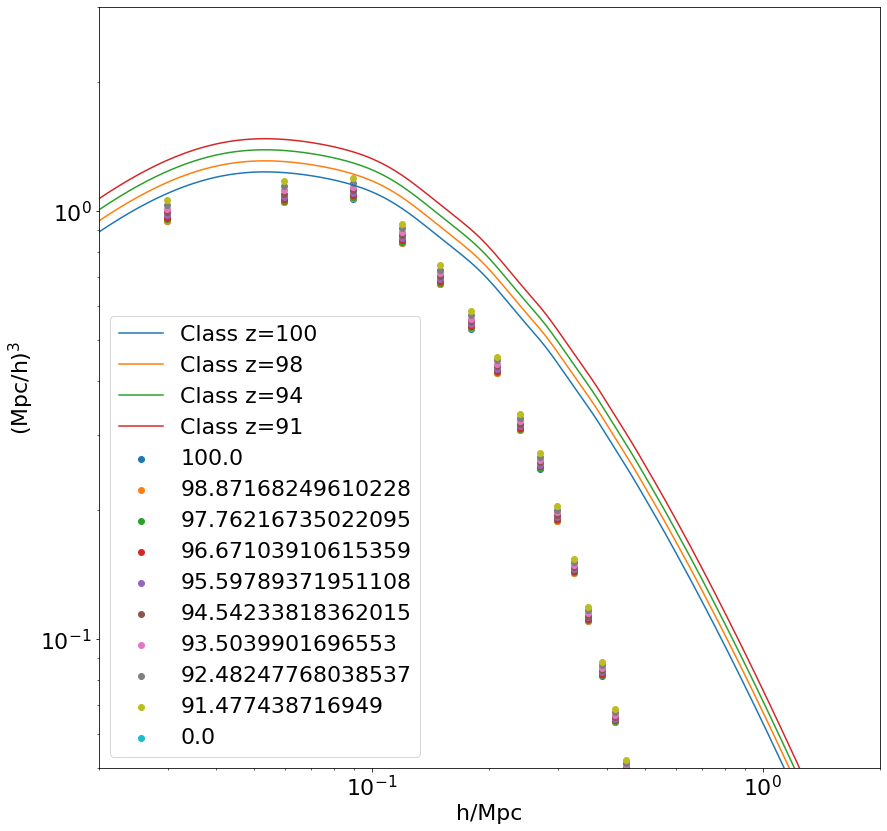

In [15]:
plt.figure(figsize=(14,14))
plt.rcParams.update({'font.size': 22})
plt.xlabel("h/Mpc")
plt.ylabel("(Mpc/h)$^{3}$")

for i in range(10):
    plt.scatter(k_power_spectrum[1:],power_spectrum_array[i*2][1:],label=red_shift[i*2])

plt.loglog(Pk_class_z100_file[:,0],Pk_class_z100_file[:,1],label="Class z=100")
plt.loglog(Pk_class_z98_file[:,0],Pk_class_z98_file[:,1],label="Class z=98")
# plt.loglog(Pk_class_z95_file[:,0],Pk_class_z95_file[:,1],label="Class z=95")
plt.loglog(Pk_class_z94_file[:,0],Pk_class_z94_file[:,1],label="Class z=94")
plt.loglog(Pk_class_z91_file[:,0],Pk_class_z91_file[:,1],label="Class z=91")


# plt.loglog(Pk_gevolution_z100_file[:,0],Pk_gevolution_z100_file[:,1]*(((2*np.pi)**3/(4*np.pi))/Pk_gevolution_z95_file[:,0]**3),label="z = 100")
# plt.loglog(Pk_gevolution_z98_file[:,0],Pk_gevolution_z98_file[:,1]*(((2*np.pi)**3/(4*np.pi))/Pk_gevolution_z95_file[:,0]**3),label="z = 98")
# plt.loglog(Pk_gevolution_z95_file[:,0],Pk_gevolution_z95_file[:,1]*(((2*np.pi)**3/(4*np.pi))/Pk_gevolution_z95_file[:,0]**3),label="z = 95")
# plt.loglog(Pk_gevolution_z94_file[:,0],Pk_gevolution_z94_file[:,1]*(((2*np.pi)**3/(4*np.pi))/Pk_gevolution_z95_file[:,0]**3),label="z = 94")
# plt.loglog(Pk_gevolution_z91_file[:,0],Pk_gevolution_z91_file[:,1]*(((2*np.pi)**3/(4*np.pi))/Pk_gevolution_z95_file[:,0]**3),label="z = 91")

# plt.plot(N_body_z_99[1:,0],N_body_z_99[1:,1],'--',label="Z = 99")
# plt.plot(N_body_z_96[1:,0],N_body_z_96[1:,1],'--',label="Z = 96")
# plt.plot(N_body_z_93[1:,0],N_body_z_93[1:,1],'--',label="Z = 93")

# plt.plot(N_body_z_99_vby10[1:,0],N_body_z_99_vby10[1:,1],'--',label="Z = 99/10")
# plt.plot(N_body_z_96_vby10[1:,0],N_body_z_96_vby10[1:,1],'--',label="Z = 96/10")
# plt.plot(N_body_z_91_vby10[1:,0],N_body_z_91_vby10[1:,1],'--',label="Z = 91/10")

plt.xlim(0.02,2)
plt.ylim(0.05,3)
plt.legend()

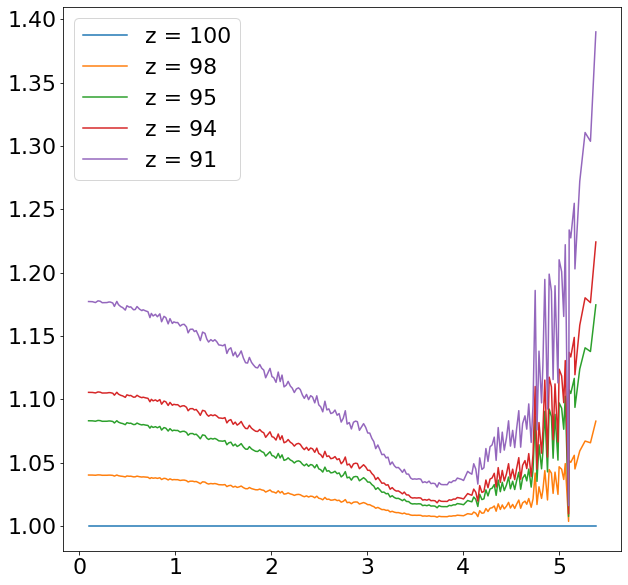

In [12]:
plt.figure(figsize=(10,10))
plt.plot(Pk_gevolution_z100_file[:,0],Pk_gevolution_z100_file[:,1]/Pk_gevolution_z100_file[:,1],label="z = 100")
plt.plot(Pk_gevolution_z98_file[:,0],Pk_gevolution_z98_file[:,1]/Pk_gevolution_z100_file[:,1],label="z = 98")
plt.plot(Pk_gevolution_z95_file[:,0],Pk_gevolution_z95_file[:,1]/Pk_gevolution_z100_file[:,1],label="z = 95")
plt.plot(Pk_gevolution_z94_file[:,0],Pk_gevolution_z94_file[:,1]/Pk_gevolution_z100_file[:,1],label="z = 94")
plt.plot(Pk_gevolution_z91_file[:,0],Pk_gevolution_z91_file[:,1]/Pk_gevolution_z100_file[:,1],label="z = 91")
plt.legend()

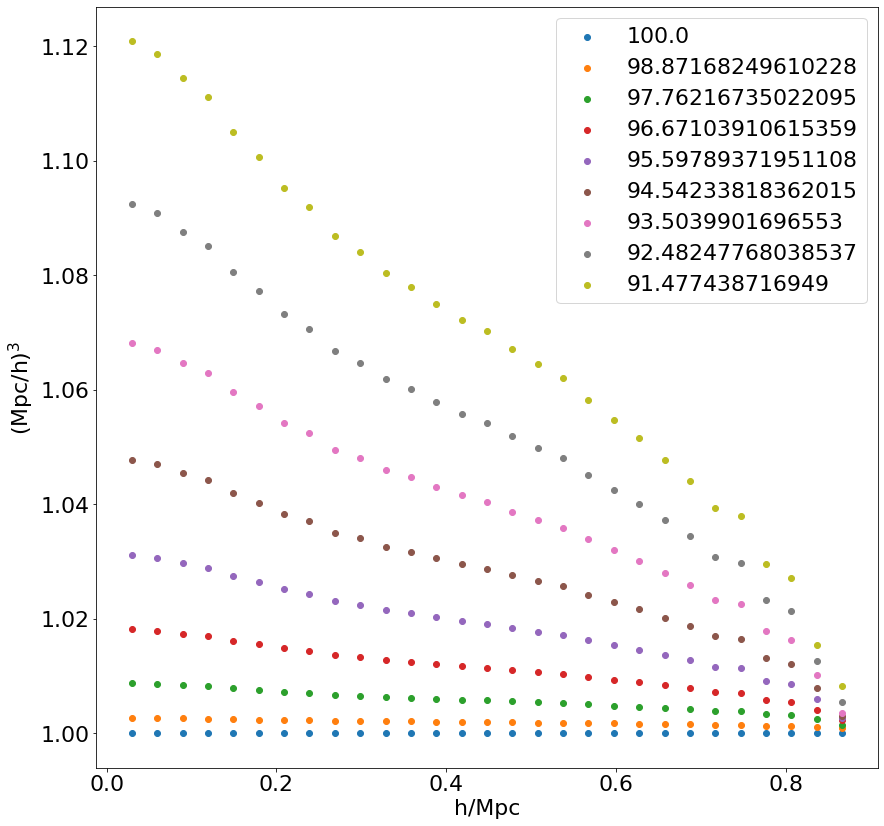

In [18]:
plt.figure(figsize=(14,14))
plt.rcParams.update({'font.size': 22})
plt.xlabel("h/Mpc")
plt.ylabel("(Mpc/h)$^{3}$")

for i in range(9):
    plt.scatter(k_power_spectrum[1:],power_spectrum_array[i*2][1:]/power_spectrum_array[0][1:],label=red_shift[i*2])
    
    plt.legend()

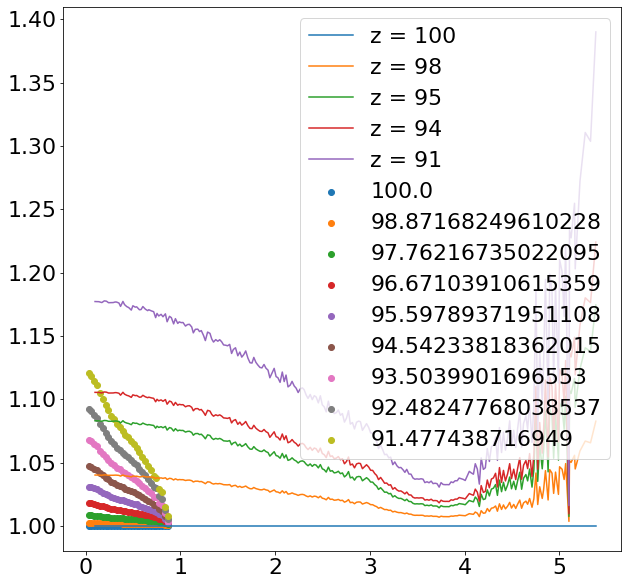

In [21]:
plt.figure(figsize=(10,10))
plt.plot(Pk_gevolution_z100_file[:,0],Pk_gevolution_z100_file[:,1]/Pk_gevolution_z100_file[:,1],label="z = 100")
plt.plot(Pk_gevolution_z98_file[:,0],Pk_gevolution_z98_file[:,1]/Pk_gevolution_z100_file[:,1],label="z = 98")
plt.plot(Pk_gevolution_z95_file[:,0],Pk_gevolution_z95_file[:,1]/Pk_gevolution_z100_file[:,1],label="z = 95")
plt.plot(Pk_gevolution_z94_file[:,0],Pk_gevolution_z94_file[:,1]/Pk_gevolution_z100_file[:,1],label="z = 94")
plt.plot(Pk_gevolution_z91_file[:,0],Pk_gevolution_z91_file[:,1]/Pk_gevolution_z100_file[:,1],label="z = 91")


for i in range(9):
    plt.scatter(k_power_spectrum[1:],power_spectrum_array[i*2][1:]/power_spectrum_array[0][1:],label=red_shift[i*2])
    
plt.legend()